In [9]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

In [10]:
# 2. Load & Inspect Data
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

In [11]:
# 3. Preprocess Data

def preprocess_data(df):
    # Drop ID column
    df = df.drop('customerID', axis=1)
    
    # Convert TotalCharges
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    # Binary encoding
    binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                   'PaperlessBilling', 'Churn']
    
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

    # One-hot encoding
    multi_class_cols = [
        'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
    ]

    df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

    # Feature engineering
    df['AvgCharges'] = df['TotalCharges'] / (df['tenure'] + 1)
    df['LongTermCustomer'] = (df['tenure'] > 24).astype(int)
    df['HighMonthlyCharge'] = (df['MonthlyCharges'] > 80).astype(int)

    return df


In [12]:
# 4. Train-Test Split + Scaling
def split_and_scale(df):
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test


In [13]:
# 5. Train Logistic Regression
def train_logistic_regression(X_train_scaled, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)
    return model


In [14]:
# 6. Train Random Forest (With GridSearch)

def train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced']
    }

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    return grid.best_estimator_


In [15]:
# XGBOOST
def train_xgboost(X_train, y_train):
    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model


In [16]:
# 7. Model Evaluation

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


In [17]:
# ROC CURVE PLOT
def plot_roc_curve(models, y_test):
    plt.figure(figsize=(8,6))

    for name, (model, X_test) in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.show()


In [18]:
# 8. Feature Importance Plot

def plot_feature_importance(model, X):
    importances = model.feature_importances_
    features = X.columns

    feat_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=feat_df)
    plt.title("Top 15 Feature Importances")
    plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_15820\1537029959.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)



Logistic Regression Results
Accuracy: 0.808374733853797
ROC AUC: 0.8466377328269913
[[938  97]
 [173 201]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Random Forest Results
Accuracy: 0.7700496806245565
ROC AUC: 0.8416221033868094
[[808 227]
 [ 97 277]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


XGBoost Results
Accuracy: 0.7998580553584103
ROC AUC: 0.8389250561884835
[[930 105]
 [177 197]]
              precision    recall  f1-

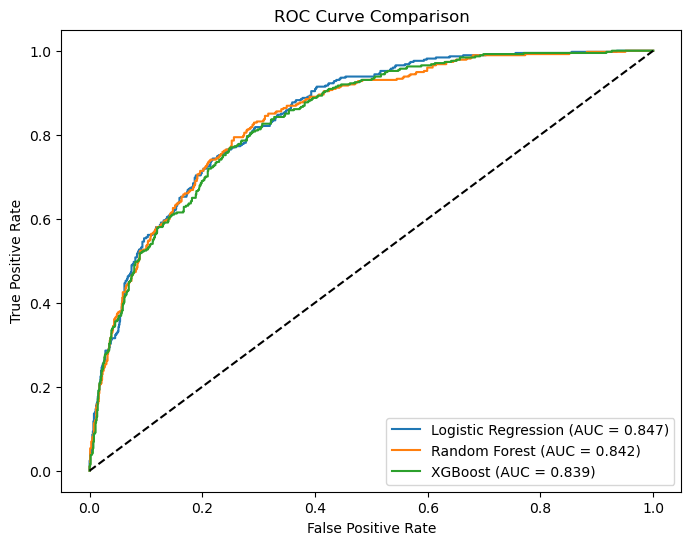

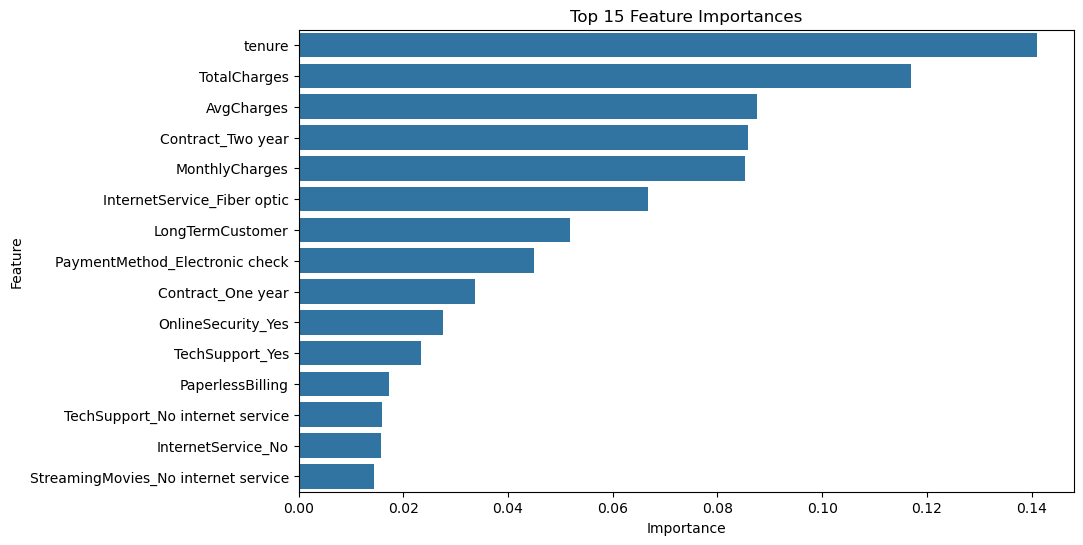

In [19]:
# 9. Main Function

def main():
    df = load_data('Telco-Customer-Churn.csv')
    df = preprocess_data(df)
    X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(df)
    # Train models
    lr_model = train_logistic_regression(X_train_scaled, y_train)
    rf_model = train_random_forest(X_train, y_train)
    xgb_model = train_xgboost(X_train, y_train)
    # Evaluate models
    evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
    evaluate_model(rf_model, X_test, y_test, "Random Forest")
    evaluate_model(xgb_model, X_test, y_test, "XGBoost")
    # ROC Curve comparison
    models_for_roc = {
        "Logistic Regression": (lr_model, X_test_scaled),
        "Random Forest": (rf_model, X_test),
        "XGBoost": (xgb_model, X_test)
    }
    plot_roc_curve(models_for_roc, y_test)
    # Feature importance (Random Forest)
    plot_feature_importance(rf_model, X_train)


if __name__ == "__main__":
    main()
